##**UTILITY FUNCTIONS**

In [837]:
import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict


def split_data(X, y, test_size=0.1, seed=None):
    # shuffle data
    np.random.seed(seed)
    perm = np.random.permutation(X.index)
    X = X.loc[perm]
    y = y.loc[perm]
    
    # split into training and test sets
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        if test_size <= 0 or test_size >= 1:
            raise ValueError("The test size should fall in the range (0,1)")
        n_train = n_samples - round(test_size*n_samples)
    elif isinstance(test_size, int):
        n_train = n_samples - test_size
    else:
        raise ValueError("Improper type \'%s\' for test_size" % type(test_size))

    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, X_test, y_train, y_test

def encode_one_hot(data): # note: pd.get_dummies(df) does the same
    # https://www.kite.com/python/answers/how-to-do-one-hot-encoding-with-numpy-in-python
    one_hot = np.zeros((data.size, data.max()+1))
    rows = np.arange(data.size)
    one_hot[rows, data] = 1
    return one_hot

def check_RandomState(random_state):
    """ Parse different input types for the random state"""
    if  random_state is None: 
        rng = np.random.RandomState() 
    elif isinstance(random_state, int): 
        # seed the random state with this integer
        rng = np.random.RandomState(random_state) 
    elif isinstance(random_state, np.random.RandomState):
        rng = random_state
    else:
        raise ValueError ("improper type \'%s\' for random_state parameter" % type(random_state))
    return rng

def check_sample_size(sample_size, n_samples: int):
    if sample_size is None:
        n = n_samples
    elif isinstance(sample_size, int):
        if sample_size == 1:
            warnings.warn("Interpreting sample_size as 1 sample. Use sample_size=1.0 for 100% of the data")
        n = min(sample_size, n_samples)
    elif isinstance(sample_size, float):
        frac = min(sample_size, 1)
        n = int(frac*n_samples)
    else:
        raise ValueError("Improper type \'%s\' for sample_size" %type(sample_size))
    return n

def confusion_matrix(y_actual, y_pred):
    """ Returns a confusion matrix where the rows are the actual classes, and the columns are the predicted classes"""
    if y_actual.shape != y_pred.shape:
        raise ValueError ("input arrays must have the same shape, {}!={}".format(y_actual.shape, y_pred.shape))
    n = max(max(y_actual), max(y_pred)) + 1
    C = np.zeros((n, n), dtype=int)
    for label_actual in range(n):
        idxs_true = (y_actual == label_actual)
        for label_pred in range(n):
            C[label_actual, label_pred] = sum(y_pred[idxs_true] == label_pred)
    return C

def calc_f1_score(y_actual, y_pred) -> Tuple[float]:
    C = confusion_matrix(y_actual, y_pred)
    if C.shape[0] != 2:
        raise ValueError ("input arrays must only have binary values")
    recall    = C[1][1]/(C[1][0]+C[1][1]) #true positive/actual positive
    precision = C[1][1]/(C[0][1]+C[1][1]) #true positive/predicted positive
    if (recall == 0) or (precision == 0):
        f1 = 0
    else:
        f1 = 2 * recall*precision/(recall + precision) # = 2/((1/recall)+(1/precision))

    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("F1 Score: {:.4f}".format(f1))


##**DECISION TREE FUNCTIONS**

In [838]:
import warnings
def gini_score(counts: List[int]) -> float: 
    score = 1
    n = sum(counts)
    for c in counts:
        p = c/n
        score -= p*p
    return score

class DecisionTree:
    def __init__(self, max_depth=None, max_features=None, min_samples_leaf=1, random_state=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.RandomState = check_RandomState(random_state)

        # initialise internal variables
        self.tree_ = BinaryTree() 
        self.n_samples = []
        self.values = []
        self.impurities = []
        self.split_features = []
        self.split_values = []
        self.n_features = None
        self.n_classes = None
        self.features = None
        self.size = 0 # current node = size - 1
        
    def fit(self, X, Y):
        if Y.ndim == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable
        elif Y.shape[1] == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable

        # set internal variables
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        self.features = X.columns
        self.max_depth_ = float('inf') if self.max_depth is None else self.max_depth
        if self.max_features is not None:
            if self.max_features is 'sqrt':
                n = int(np.sqrt(self.n_features))
            elif isinstance(self.max_features, int):
                n = min(self.max_features, self.n_features)
            else:
                raise Exception('Unknown parameter \'%s\' for max_features' % self.max_features)
        else:
            n = self.n_features 
        self.n_features_split = n

        # initial split which recursively calls itself
        self._split_node(X, Y) 

        # set attributes
        self.feature_importances_ = self.impurity_feature_importance()
        self.depths = self.tree_.find_depths()

    def get_n_splits(self) -> int:
        "The number of nodes (number of parameters/2) not counting the leaves in the tree"
        return self.tree_.n_splits
    
    def get_n_leaves(self) -> int:
        "The number of leaves (nodes without children) in the tree"
        return self.tree_.n_leaves

    def get_max_depth(self) -> int:
        "The maximum depth in the tree"
        return self.tree_.get_max_depth(0)

    def is_leaf(self, node_id: int) -> bool:
        return self.tree_.is_leaf(node_id)
    
    def split_name(self, node_id: int) -> str:
        return self.features[self.split_features[node_id]]

    def _set_defaults(self, node_id: int, Y):
        val = Y.sum(axis=0)
        self.values.append(val)
        self.impurities.append(gini_score(val))
        self.split_features.append(None)
        self.split_values.append(None)
        self.n_samples.append(Y.shape[0])
        self.tree_.add_node()
    
    def _split_node(self, X0, Y0):
        stack = [(X0, Y0, -1, -1, 0)] # stack = [(X, Y, parent, side, depth)]
        while stack:
            X, Y, parent, side, depth = stack.pop()
            node_id = self.size
            self.size += 1
            self._set_defaults(node_id, Y)
            if side is 0:
                self.tree_.set_left_child(parent, node_id)
            elif side is 1:
                self.tree_.set_right_child(parent, node_id)
            if self.impurities[node_id] == 0: # only one class in this node
                continue
            
            # random shuffling removes any bias due to the feature order
            features = self.RandomState.permutation(self.n_features)[:self.n_features_split]

            # make the split
            best_score = float('inf')
            for i in features:
                best_score= self._find_bettersplit(i, X, Y, node_id, best_score)
            if best_score == float('inf'):
                continue


            # make children
            if depth < self.max_depth_: 
                x_split = X.values[:, self.split_features[node_id]]
                lhs = np.nonzero(x_split<=self.split_values[node_id])
                rhs = np.nonzero(x_split> self.split_values[node_id])
                stack.append((X.iloc[rhs], Y[rhs[0], :], node_id, 1, depth+1)) # right first in, last out
                stack.append((X.iloc[lhs], Y[lhs[0], :], node_id, 0, depth+1)) # left first out

    
    def _find_bettersplit(self, var_idx: int, X, Y, node_id: int, best_score:float) -> float:
        X = X.values[:, var_idx] 
        n_samples = self.n_samples[node_id]

        # sort the variables. 
        order = np.argsort(X)
        X_sort, Y_sort = X[order], Y[order, :]

        #Start with all on the right. Then move one sample to left one at a time
        rhs_count = Y.sum(axis=0)
        lhs_count = np.zeros(rhs_count.shape)
        for i in range(0, len(X_sort)-1):
            xi, yi = X_sort[i], Y_sort[i, :]
            lhs_count += yi;  rhs_count -= yi
            if (xi == X_sort[i+1]) or (sum(lhs_count) < self.min_samples_leaf):
                continue
            if sum(rhs_count) < self.min_samples_leaf:
                break
            # Gini Impurity
            lhs_gini = gini_score(lhs_count)
            rhs_gini = gini_score(rhs_count)
            curr_score = (lhs_gini * lhs_count.sum() + rhs_gini * rhs_count.sum())/n_samples
            if curr_score < best_score:
                self.split_features[node_id] = var_idx
                best_score = curr_score
                self.split_values[node_id]= (xi + X_sort[i+1])/2
        return best_score

    def _predict_row(self, xi):
        next_node = 0
        while not self.is_leaf(next_node):
            left, right = self.tree_.get_children(next_node)
            next_node = left if xi[self.split_features[next_node]] <= self.split_values[next_node] else right
        return self.values[next_node]

    def _predict_batch(self, X, node=0):
        # Helper function for predict_prob(). Predicts multiple batches of a row at time. Faster than _predict_row(self, xi)
        if self.is_leaf(node):
            return self.values[node]
        if len(X) == 0:
            return np.empty((0, self.n_classes))
        left, right = self.tree_.get_children(node)

        lhs = X[:, self.split_features[node]] <= self.split_values[node]
        rhs = X[:, self.split_features[node]] >  self.split_values[node]

        probs = np.zeros((X.shape[0], self.n_classes))
        probs[lhs] = self._predict_batch(X[lhs], node=left)
        probs[rhs] = self._predict_batch(X[rhs], node=right)
        return probs

    def predict_prob(self, X):
        "Return the probability in the final leaf for each class, given as the fraction of each class in that leaf"
        if X.values.ndim == 1:
            probs = np.array([self._predict_row(X)])
        else:
            #start_time = time.time()
            #probs = np.apply_along_axis(self._predict_row, 1, X.values) # slow because this is a for loop
            probs = self._predict_batch(X.values)
            #end_time = time.time()
            #print('%.1fms' % ((end_time-start_time)*1000))
            probs /= np.sum(probs, axis=1)[:, None]
        return probs

    def predict(self, X):
        "Return the most likely class in the final leaf"
        probs = self.predict_prob(X)
        return np.nanargmax(probs, axis=1)

    def predict_count(self, X):
        "Return the sample count in the final leaf for each class"
        if X.values.ndim == 1:
            return np.array([self._predict_row(X.values)])
        return np.apply_along_axis(self._predict_row, 1, X.values)

    def impurity_feature_importance(self):
        """Calculate feature importance weighted by the number of samples affected by this feature at each split point. """
        feature_importances = np.zeros(self.n_features)
        total_samples = self.n_samples[0]
        for node in range(len(self.impurities)):
            if self.is_leaf(node):
                continue 
            spit_feature = self.split_features[node]
            impurity = self.impurities[node]
            n_samples = self.n_samples[node]
            # calculate score
            left, right = self.tree_.get_children(node)
            lhs_gini = self.impurities[left]
            rhs_gini = self.impurities[right]
            lhs_count = self.n_samples[left]
            rhs_count = self.n_samples[right]
            score = (lhs_gini * lhs_count + rhs_gini * rhs_count)/n_samples
            # feature_importances      = (decrease in node impurity) * (probability of reaching node ~ proportion of samples)
            feature_importances[spit_feature] += (impurity-score) * (n_samples/total_samples)

        feature_importances = feature_importances/feature_importances.sum()
        return feature_importances

    def get_info(self, node_id: int):
        n_samples =  self.n_samples[node_id]
        val =        self.values[node_id]
        impurity =   self.impurities[node_id]
        var_idx    = self.split_features[node_id]
        split_val  = self.split_values[node_id]
        if self.is_leaf(node_id):
            return n_samples, val, impurity
        else:
            return n_samples, val, var_idx, split_val, impurity

    def node_to_string(self, node_id: int) -> str:
        if self.is_leaf(node_id):
            n_samples, val, impurity = self.get_info(node_id)
            s = 'n_samples: {:d}; value: {}; impurity: {:.4f}'.format(n_samples, val.astype(int), impurity)
        else:
            n_samples, val, var_idx, split_val, impurity = self.get_info(node_id)
            split_name = self.split_name(node_id)
            s =  'n_samples: {:d}; value: {}; impurity: {:.4f}'.format(n_samples, val.astype(int), impurity)
            s += '; split: {}<={:.3f}'.format(split_name, split_val)
        return s
  

class BinaryTree():
    def __init__(self):
        self.children_left = []
        self.children_right = []

    @property
    def size(self):
        "The number of nodes in the tree"
        return len(self.children_left)

    @property
    def n_leaves(self):
        "The number of leaves (nodes without children) in the tree"
        return self.children_left.count(-1) 

    @property
    def n_splits(self):
        "The number of nodes (number of parameters/2) not counting the leaves in the tree"
        return self.size - self.n_leaves

    def add_node(self):
        self.children_left.append(-1)
        self.children_right.append(-1)
    
    def set_left_child(self, node_id: int, child_id: int):
        self.children_left[node_id] = child_id

    def set_right_child(self, node_id: int, child_id: int):
        self.children_right[node_id] = child_id

    def get_children(self, node_id: int): return self.children_left[node_id], self.children_right[node_id]

    def find_depths(self):
        depths = np.zeros(self.size, dtype=int)
        depths[0] = -1
        stack = [(0, 0)] # (parent, node_id)
        while stack:
            parent, node_id = stack.pop()
            if node_id == -1:
                continue
            depths[node_id] = depths[parent] + 1
            left = self.children_left[node_id]
            right = self.children_right[node_id]
            stack.extend([(node_id, left), (node_id, right)])
        return depths

    def is_leaf(self, node_id: int):
        left = self.children_left[node_id]
        right = self.children_right[node_id]
        return right == left #(left == -1) and (right == -1)

    def get_max_depth(self, node_id=0):
        "Calculate the maximum depth of the tree"
        if self.is_leaf(node_id):
            return 0 
        left = self.children_left[node_id]
        right = self.children_right[node_id]
        return max(self.get_max_depth(left), self.get_max_depth(right)) + 1

    def preorder(self, node_id=0):
        "Pre-order tree traversal"
        # Note: the parallel arrays are already in pre-order
        # Therefore can just return np.arange(self.size)
        if node_id != -1:
            yield node_id
        left = self.children_left[node_id]
        right = self.children_right[node_id]
        if left != -1:
            for leaf in self.preorder(left):
                yield leaf
        if right != -1:
            for leaf in self.preorder(right):
                yield leaf

<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:92: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:92: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-838-f1f57d74268e>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.max_features is 'sqrt':
<ipython-input-838-f1f57d74268e>:92: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if side is 0:
<ipython-input-838-f1f57d74268e>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif side is 1:


##**RANDOM FOREST FUNCTION**

In [839]:
import numpy as np
import pandas as pd
import warnings
import time
from typing import List, Tuple, Dict

class RandomForestClassifier:
    def __init__(self, 
                n_trees=100, 
                random_state=None, 
                max_depth=None, 
                max_features=None, 
                min_samples_leaf=1,
                sample_size=None, 
                bootstrap=True, 
                oob_score=False):
        self.n_trees = n_trees
        self.RandomState = check_RandomState(random_state)
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf=min_samples_leaf
        self.sample_size = sample_size
        self.bootstrap = bootstrap
        self.oob_score = oob_score

        self.features = None
        self.n_features = None
        self.n_classes = None
        self.feature_importances_ = None
        
    def fit(self, X, Y):
        "fit the random tree to the independent variable X, to determine the dependent variable Y"
        if Y.ndim == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable
        elif Y.shape[1] == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable

        # set internal variables
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        self.features = X.columns.values
        n_samples = X.shape[0]
        self.sample_size_ = check_sample_size(self.sample_size, n_samples)

        # create decision trees
        self.trees = []
        rng_states = [] # save the random states to regenerate the random indices for the oob_score
        for i in range(self.n_trees):
            rng_states.append(self.RandomState.get_state())
            self.trees.append(self._create_tree(X, Y))

        # set attributes
        self.feature_importances_ = self.impurity_feature_importances()
        if self.oob_score:
            if not (self.bootstrap or (self.sample_size_<n_samples)):
                warnings.warn("out-of-bag score will not be calculated because bootstrap=False")
            else:
                self.oob_score_ = self.calculate_oob_score(X, Y, rng_states)
    
    def _create_tree(self, X, Y):
        assert len(X) == len(Y), ""
        n_samples = X.shape[0]

        # get sub-sample 
        if self.bootstrap:
            rand_idxs = self.RandomState.randint(0, n_samples, self.sample_size_) # with replacement
            X_, Y_ = X.iloc[rand_idxs, :], Y[rand_idxs] # approximate unique values =n*(1-np.exp(-sample_size_/n_samples))
        elif self.sample_size_ < n_samples:
            rand_idxs = self.RandomState.permutation(np.arange(n_samples))[:self.sample_size_]  # without replacement
            X_, Y_ = X.iloc[rand_idxs, :], Y[rand_idxs]
        else:
            X_, Y_ = X.copy(), Y.copy() # do nothing to the data

        new_tree =  DecisionTree(max_depth=self.max_depth, 
                                 max_features=self.max_features,
                                 random_state=self.RandomState,
                                 min_samples_leaf=self.min_samples_leaf
                                )
        new_tree.fit(X_, Y_)
        return new_tree
                
    def predict(self, X):
        "Predict the class for each sample in X"
        probs = np.sum([t.predict_prob(X) for t in self.trees], axis=0)
        #probs = np.sum([t.predict_count(X) for t in self.trees], axis=0)
        return np.nanargmax(probs, axis=1)

    def score(self, X, y):
        "The accuracy score of random forest predictions for X to the true classes y"
        y_pred = self.predict(X)
        return np.mean(y_pred==y)

    def calculate_oob_score(self, X, Y, rng_states):
        n_samples = X.shape[0]
        oob_prob = np.zeros(Y.shape)
        oob_count = np.zeros(n_samples)
        all_samples = np.arange(n_samples)
        rng = np.random.RandomState()
        for i, state in enumerate(rng_states):
            rng.set_state(state)
            if self.bootstrap:
                rand_idxs = rng.randint(0, n_samples, self.sample_size_)
            else: #self.sample_size_ < n_samples
                rand_idxs = rng.permutation(all_samples)[:self.sample_size_]
            row_oob = np.setxor1d(all_samples, rand_idxs)
            oob_prob[row_oob, :] += self.trees[i].predict_prob(X.iloc[row_oob])
            oob_count[row_oob] += 1
        # remove nan-values
        valid = oob_count > 0 
        oob_prob = oob_prob[valid, :]
        oob_count = oob_count[valid][:, np.newaxis] # transform to column vector for broadcasting during the division
        y_test    =  np.argmax(Y[valid], axis=1)
        # predict out-of-bag score
        y_pred = np.argmax(oob_prob/oob_count, axis=1)
        return np.mean(y_pred==y_test)

    def impurity_feature_importances(self) -> np.ndarray:
        """Calculate feature importance weighted by the number of samples affected by this feature at each split point. """
        feature_importances = np.zeros((self.n_trees, self.n_features))

        for i, tree in enumerate(self.trees):
            feature_importances[i, :] = tree.feature_importances_

        return np.mean(feature_importances, axis=0)

#**CHECKING ON DATASETS**

##**TITANIC DATASET(BINARY CLASSIFICATION)**

In [840]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

In [841]:
df = pd.read_csv("/content/TitanicData.csv")
# handling missing values
median_age = df.Age.median()
df = df.fillna({"Age": median_age})
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


0    424
1    288
Name: Survived, dtype: int64


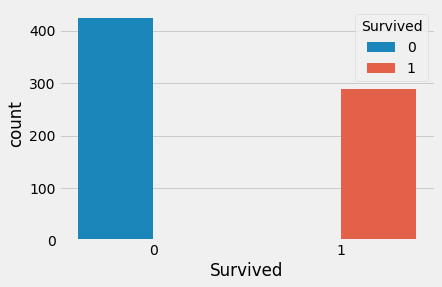

In [842]:
# TARGET DISTRIBUTION PLOT
print(df['Survived'].value_counts()) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df['Survived'], data=df, hue=df['Survived'])

####**OUTLIERS TREATMENT**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fare'>

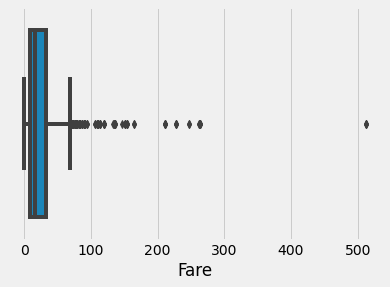

In [843]:
sns.boxplot(df['Fare'],data=df)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

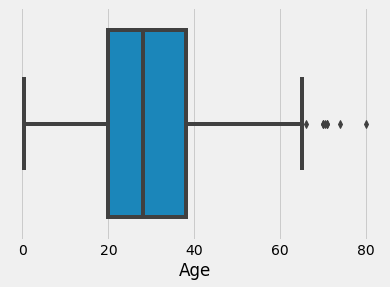

In [844]:
sns.boxplot(df['Age'],data=df)

In [845]:
#TREATMENT1: Trimming/removing outliers above and below percentiles
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
df['Fare']=np.where(df['Fare']>upper_whisker,upper_whisker,np.where(df['Fare']<lower_whisker,lower_whisker,df['Fare']))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fare'>

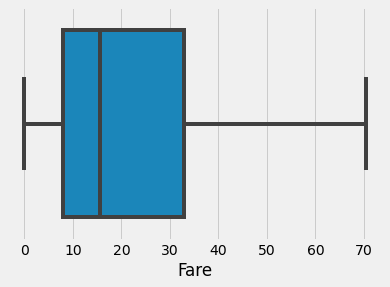

In [846]:
sns.boxplot(df['Fare'],data=df)

In [847]:
#TREATMENT2: Replacing outliers with median values
median = df.loc[df['Age']<65, 'Age'].median()
df.loc[df.Age > 65, 'Age'] 
df.fillna(median,inplace=True)
df["Age"] = df["Age"].mask(df["Age"] >60, median)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

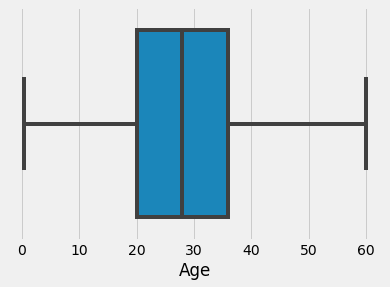

In [848]:
sns.boxplot(df['Age'],data=df)

###**MODEL BUILDING AND PREDICTIONS**

In [849]:
X=df.drop(['Survived'],axis=1)
y=df.Survived

In [850]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

In [851]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((570, 6), (570,), (142, 6), (142,))

In [852]:
rfc = RandomForestClassifier(n_trees=10, bootstrap=True, max_features=5, min_samples_leaf=3,random_state=123)
rfc.fit(X_train, y_train)
acc_test = rfc.score(X_test, y_test)
acc_train = rfc.score(X_train, y_train)
y_train_pred= rfc.predict(X_train)
y_pred= rfc.predict(X_test)
print("Random Forest model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))

Random Forest model
train accuracy: 91.58%
test accuracy:  84.51%


####**MODEL EVALUATION**

In [853]:
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy
def precision(y_true, y_pred):
    true_positives = sum((y_true == 1) & (y_pred == 1))
    false_positives = sum((y_true == 0) & (y_pred == 1))
    precision = true_positives / (true_positives + false_positives + 1e-7)
    return precision


def recall(y_true, y_pred):
    true_positives = sum((y_true == 1) & (y_pred == 1))
    false_negative = sum((y_true == 1) & (y_pred == 0))
    recall = true_positives / (true_positives + false_negative + 1e-7) 
    return recall

def f1_score(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    fp = sum((y_true == 0) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fn = sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_score


# getting all the performane metrics and stored it in a dataframe

scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = calculate_accuracy(train_actual,train_predicted)
    train_recall   = recall(train_actual,train_predicted)
    train_precision= precision(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = calculate_accuracy(test_actual,test_predicted)
    test_recall   = recall(test_actual,test_predicted)
    test_precision= precision(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

In [854]:
# Used a customised function for getting reports
scores = get_metrics(y_train,y_train_pred,y_test,y_pred,"RandomforestClassifier",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,RandomforestClassifier,0.915789,0.838565,0.939698,0.886256,0.84507,0.830769,0.830769,0.830769


In [855]:
calc_f1_score(y_test,y_pred)

Recall: 0.8308
Precision: 0.8308
F1 Score: 0.8308


In [856]:
confusion_matrix(y_test,y_pred)

array([[66, 11],
       [11, 54]])

##**MOBILE PRICE RANGE DATASET(MULTI CLASSIFICATION)**

In [857]:
# Read the CSV Files
df1 = pd.read_csv('/content/train (1).csv')
df1.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [858]:
# Check the files whether they have any empty cell or not
df1.isnull().sum().sum()

0

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64


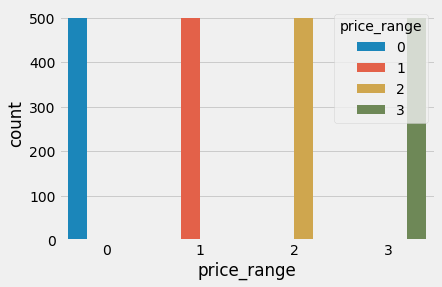

In [859]:
# TARGET DISTRIBUTION PLOT
print(df1['price_range'].value_counts()) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df1.price_range, data=df1, hue=df1.price_range)

###**MODEL BUILDING**

In [788]:
X=df1.drop(['price_range'],axis=1)
y=df1.price_range

In [789]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

In [790]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1600, 20), (1600,), (400, 20), (400,))

In [791]:
rfc = RandomForestClassifier(n_trees=20, bootstrap=True, max_features=5, min_samples_leaf=5,random_state=0)
rfc.fit(X_train, y_train)
y_pred= rfc.predict(X_test)
acc_test = rfc.score(X_test, y_test)
acc_train = rfc.score(X_train, y_train)
print("Random Forest model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))

Random Forest model
train accuracy: 98.62%
test accuracy:  88.00%


####**MODEL EVALUATION**

In [792]:
confusion_matrix(y_test,y_pred)

array([[104,   5,   0,   0],
       [  7,  86,   5,   0],
       [  0,  10,  74,  12],
       [  0,   0,   9,  88]])

#**CUSTOMER SEGMENTATION DATASET**

In [793]:
df01 = pd.read_csv("/content/Train.csv")
df1 = df01.copy()
df1.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


###**EDA ON DATASET**

####**MISSING VALUE TREATEMENT**

In [794]:
# Checking the number of missing values in each column
df1.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [795]:
# Removing all those rows that have 3 or more missing values
df1 = df1.loc[df1.isnull().sum(axis=1)<3]
df1.isnull().sum()

ID                   0
Gender               0
Ever_Married       134
Age                  0
Graduated           72
Profession         113
Work_Experience    813
Spending_Score       0
Family_Size        320
Var_1               72
Segmentation         0
dtype: int64

**Var_1**

In [796]:
print('The count of each category\n',df1.Var_1.value_counts())

The count of each category
 Cat_6    5232
Cat_4    1084
Cat_3     820
Cat_2     422
Cat_7     201
Cat_1     133
Cat_5      85
Name: Var_1, dtype: int64


In [797]:
# Filling the missing values w.r.t other attributes underlying pattern 
df1.loc[ (pd.isnull(df1['Var_1'])) & (df1['Graduated'] == 'Yes'),"Var_1"] = 'Cat_6'
df1.loc[ (pd.isnull(df1['Var_1'])) & (df1['Graduated'] == 'No'),"Var_1"] = 'Cat_4'
df1.loc[ (pd.isnull(df1["Var_1"])) & ((df1['Profession'] == 'Lawyer') | (df1['Profession'] == 'Artist')),"Var_1"] = 'Cat_6'
df1.loc[ (pd.isnull(df1["Var_1"])) & (df1['Age'] > 40),"Var_1"] = 'Cat_6'

Var_1         Cat_1  Cat_2  Cat_3  Cat_4  Cat_5  Cat_6  Cat_7
Segmentation                                                 
A                31     83    223    340     19   1220     49
B                26    106    186    233     20   1241     43
C                26     99    153    118     18   1507     47
D                50    134    258    426     28   1303     62


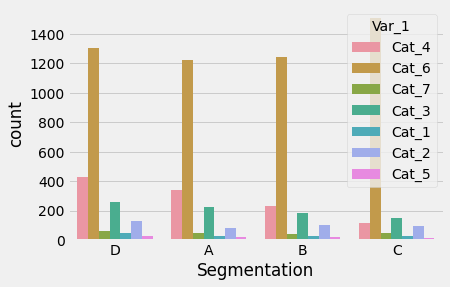

In [798]:
print(df1.groupby(["Segmentation"])["Var_1"].value_counts().unstack().round(3)) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df1.Segmentation, data=df1, hue=df1.Var_1)

**OBSERVATIONS**

In each of the segment the count of cat_6 is very high i.e. most of the entries in the given data belongs to cat_6.



---



---



**Ever_Married**

In [799]:
print('Count of married vs not married\n',df1.Ever_Married.value_counts())

Count of married vs not married
 Yes    4635
No     3280
Name: Ever_Married, dtype: int64


In [800]:
# Checking the count of missing values
df1.Ever_Married.isnull().sum()

134

In [801]:
# Filling the missing values w.r.t other attributes underlying pattern
df1.loc[ (pd.isnull(df1["Ever_Married"])) & ((df1['Spending_Score'] == 'Average') | (df1['Spending_Score'] == 'High')),"Ever_Married"] = 'Yes'
df1.loc[ (pd.isnull(df1["Ever_Married"])) & (df1['Spending_Score'] == 'Low'),"Ever_Married"] = 'No'
df1.loc[ (pd.isnull(df1["Ever_Married"])) & (df1['Age'] > 40),"Ever_Married"] = 'Yes'
df1.loc[ (pd.isnull(df1["Ever_Married"])) & (df1['Profession'] == 'Healthcare'),"Ever_Married"] = 'No'

Ever_Married    No   Yes
Segmentation            
A              814  1151
B              491  1364
C              409  1559
D             1629   632


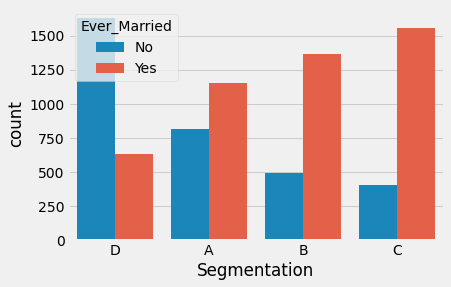

In [802]:
print(df1.groupby(["Segmentation"])["Ever_Married"].value_counts().unstack().round(3)) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df1.Segmentation, data=df1, hue=df1.Ever_Married)

**OBSERVATIONS**

We seen that most of the customers in segment C are married while segment D has least number of married customers. It means segment D is a group of customers that are singles and maybe younger in age.



---



---



**Graduated**

In [803]:
print('Count of each graduate and non-graduate\n',df1.Graduated.value_counts())

Count of each graduate and non-graduate
 Yes    4965
No     3012
Name: Graduated, dtype: int64


In [804]:
# Filling the missing values w.r.t other attributes underlying pattern
df1.loc[ (pd.isnull(df1["Graduated"])) & (df1['Spending_Score'] == 'Average'),"Graduated"] = 'Yes'
df1.loc[ (pd.isnull(df1["Graduated"])) & (df1['Profession'] == 'Artist'),"Graduated"] = 'Yes'
df1.loc[ (pd.isnull(df1["Graduated"])) & (df1['Age'] > 49),"Graduated"] = 'Yes'
df1.loc[ (pd.isnull(df1["Graduated"])) & (df1['Var_1'] == 'Cat_4'),"Graduated"] = 'No'
df1.loc[ (pd.isnull(df1["Graduated"])) & (df1['Ever_Married'] == 'Yes'),"Graduated"] = 'Yes'

# Replacing remaining NaN with previous values
df1['Graduated'] = df1['Graduated'].fillna(method='pad')

Graduated       No   Yes
Segmentation            
A              730  1235
B              508  1347
C              349  1619
D             1439   822


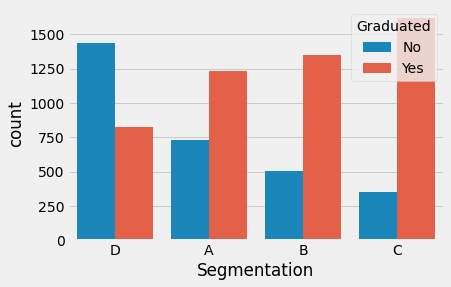

In [805]:
print(df1.groupby(["Segmentation"])["Graduated"].value_counts().unstack().round(3)) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df1.Segmentation, data=df1, hue=df1.Graduated)

**OBSERVATIONS**

Segment C has most number of customers who are graduated while segment D has lowest number of graduate customers.



---



---



**Profession**

In [806]:
print('Count of each profession\n',df1.Profession.value_counts())

Count of each profession
 Artist           2515
Healthcare       1331
Entertainment     949
Engineer          699
Doctor            688
Lawyer            619
Executive         598
Marketing         291
Homemaker         246
Name: Profession, dtype: int64


In [807]:
# Filling the missing values w.r.t other attributes underlying pattern
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Work_Experience'] > 8),"Profession"] = 'Homemaker'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Age'] > 70),"Profession"] = 'Lawyer'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Family_Size'] < 3),"Profession"] = 'Lawyer'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Spending_Score'] == 'Average'),"Profession"] = 'Artist'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Graduated'] == 'Yes'),"Profession"] = 'Artist'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Ever_Married'] == 'Yes'),"Profession"] = 'Artist'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Ever_Married'] == 'No'),"Profession"] = 'Healthcare'
df1.loc[ (pd.isnull(df1["Profession"])) & (df1['Spending_Score'] == 'High'),"Profession"] = 'Executives'

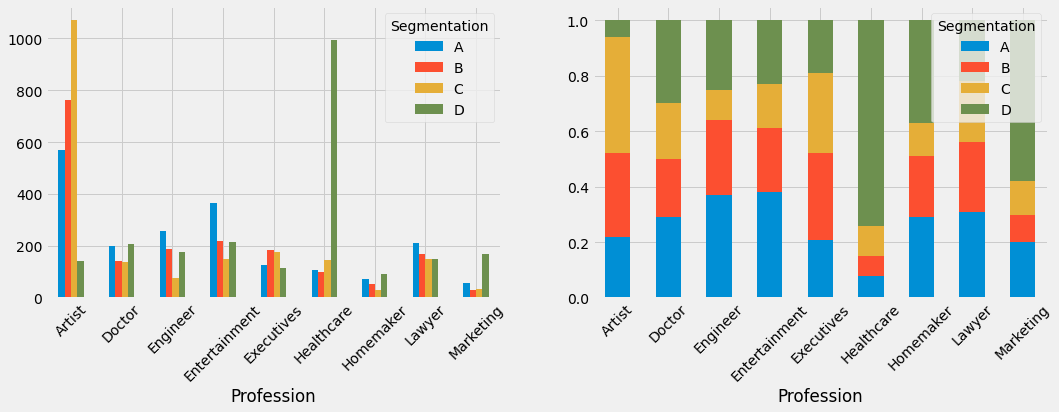

In [808]:
# Count of segments in each profession
ax1 = df1.groupby(["Profession"])["Segmentation"].value_counts().unstack().round(3)

# Percentage of segments in each profession
ax2 = df1.pivot_table(columns='Segmentation',index='Profession',values='ID',aggfunc='count')
ax2 = ax2.div(ax2.sum(axis=1), axis = 0).round(2)

#count plot
fig, ax = plt.subplots(1,2)
ax1.plot(kind="bar",ax = ax[0],figsize = (16,5))
label = ['Artist','Doctor','Engineer','Entertainment','Executives','Healthcare','Homemaker','Lawyer','Marketing']
ax[0].set_xticklabels(labels = label,rotation = 45)

#stacked bars
ax2.plot(kind="bar",stacked = True,ax = ax[1],figsize = (16,5))
ax[1].set_xticklabels(labels = label,rotation = 45)

plt.show()

**OBSEVATIONS**

Segment A,B and C have major customers from profession:Artist while Segment D have major customers from profession:Healthcare
Homemaker is least in all the four segment



---



---



**Work_Experience**

In [809]:
# Replacing NaN with previous values
df1['Work_Experience'] = df1['Work_Experience'].fillna(method='pad')

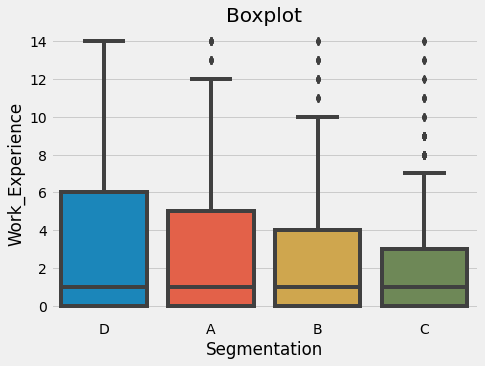

In [810]:
# Looking the distribution of column Work_Experience w.r.t to each segment
a = df1[df1.Segmentation =='A']["Work_Experience"]
b = df1[df1.Segmentation =='B']["Work_Experience"]
c = df1[df1.Segmentation =='C']["Work_Experience"]
d = df1[df1.Segmentation =='D']["Work_Experience"]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data = df1, x = "Segmentation", y="Work_Experience")
plt.title('Boxplot')
plt.show()

**OBSEVATIONS**

Segment D has people with relatively more experienced than other segments while Segment C has people with low experience

In [811]:
# Changing the data type
df1['Work_Experience'] = df1['Work_Experience'].astype(int)

# Dividing the people into 3 category of work experience 
df1['Work_Exp_Category'] = pd.cut(df1.Work_Experience,bins=[-1,1,7,15],labels=['Low Experience','Medium Experience','High Experience'])



---



---



**Family_Size**

In [812]:
# Filling the missing values w.r.t other attributes underlying pattern
df1.loc[ (pd.isnull(df1["Family_Size"])) & (df1['Ever_Married'] == 'Yes'),"Family_Size"] = 2.0
df1.loc[ (pd.isnull(df1["Family_Size"])) & (df1['Var_1'] == 'Cat_6'),"Family_Size"] = 2.0
df1.loc[ (pd.isnull(df1["Family_Size"])) & (df1['Graduated'] == 'Yes'),"Family_Size"] = 2.0

# Fill remaining NaN with previous values
df1['Family_Size'] = df1['Family_Size'].fillna(method='pad')

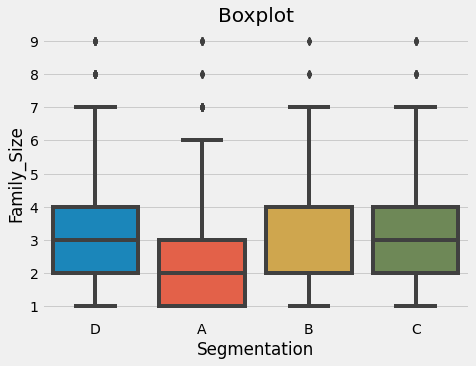

In [813]:
# Looking the distribution of column Family Size w.r.t to each segment
a = df1[df1.Segmentation =='A']["Family_Size"]
b = df1[df1.Segmentation =='B']["Family_Size"]
c = df1[df1.Segmentation =='C']["Family_Size"]
d = df1[df1.Segmentation =='D']["Family_Size"]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data = df1, x = "Segmentation", y="Family_Size")
plt.title('Boxplot')
plt.show()

In [814]:
# Changing the data type
df1['Family_Size'] = df1['Family_Size'].astype(int)

In [815]:
# Divide family size into 3 category
df1['Family_Size_Category'] = pd.cut(df1.Family_Size,bins=[0,4,6,10],labels=['Small Family','Big Family','Joint Family'])



---



---



**Age**

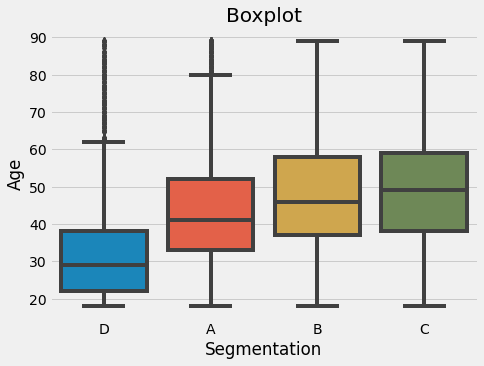

In [816]:
# Looking the distribution of column Age Size w.r.t to each segment
a = df1[df1.Segmentation =='A']["Age"]
b = df1[df1.Segmentation =='B']["Age"]
c = df1[df1.Segmentation =='C']["Age"]
d = df1[df1.Segmentation =='D']["Age"]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data = df1, x = "Segmentation", y="Age")
plt.title('Boxplot')
plt.show()

**OBSERVATIONS**

we can say that people in this segment are belong to 30s i.e. they are younger and also from 'ever_married' distribution it is seen that segment D has maximum number of customers who are singles indicating they are younger.
Also segment C has mean age of 49 and we also seen that most cutomers in this segment are married.

In [817]:
# Converting the datatype from float to int
df['Age'] = df['Age'].astype(int)

In [818]:
# Divide people in the 4 age group
df1['Age_Bin'] = pd.cut(df1.Age,bins=[17,30,45,60,90],labels=['17-30','31-45','46-60','60+'])

In [819]:
df1.isnull().sum().sum()

0

****

####**CATEGORICAL TO NUMERICAL CONVERSION**

In [820]:
# converting binary variables to numeric
df1['Gender'] = df1['Gender'].replace(('Male','Female'),(1,0))
df1['Ever_Married'] = df1['Ever_Married'].replace(('Yes','No'),(1,0))
df1['Graduated'] = df1['Graduated'].replace(('Yes','No'),(1,0))
df1['Spending_Score'] = df1['Spending_Score'].replace(('High','Average','Low'),(3,2,1))

# converting nominal variables into dummy variables
pf = pd.get_dummies(df1.Profession,prefix='Profession')
df1 = pd.concat([df1,pf],axis=1)

vr = pd.get_dummies(df1.Var_1,prefix='Var_1')
df1 = pd.concat([df1,vr],axis=1)

# scaling continuous variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1[['Age','Work_Experience','Family_Size']] = scaler.fit_transform(df1[['Age','Work_Experience','Family_Size']])

df1.drop(['ID','Age_Bin','Profession','Work_Exp_Category','Family_Size_Category','Var_1'], axis=1, inplace=True)

In [821]:
df1.shape

(8049, 24)

In [822]:
df1['Segmentation'] = df1['Segmentation'].replace(('A','B','C','D'),(1,2,3,4))

In [823]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8049 entries, 0 to 8067
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    8049 non-null   int64  
 1   Ever_Married              8049 non-null   int64  
 2   Age                       8049 non-null   float64
 3   Graduated                 8049 non-null   int64  
 4   Work_Experience           8049 non-null   float64
 5   Spending_Score            8049 non-null   int64  
 6   Family_Size               8049 non-null   float64
 7   Segmentation              8049 non-null   int64  
 8   Profession_Artist         8049 non-null   uint8  
 9   Profession_Doctor         8049 non-null   uint8  
 10  Profession_Engineer       8049 non-null   uint8  
 11  Profession_Entertainment  8049 non-null   uint8  
 12  Profession_Executive      8049 non-null   uint8  
 13  Profession_Healthcare     8049 non-null   uint8  
 14  Professi

####**OUTLIERS TREATMENT**

**Age**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

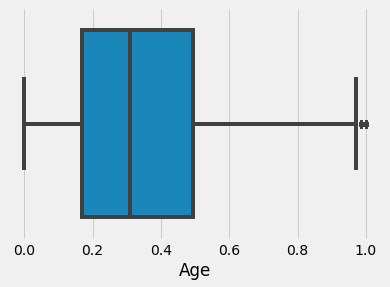

In [824]:
sns.boxplot(df1['Age'],data=df1)

In [825]:
#TREATMENT1: Trimming/removing outliers above and below percentiles
Q1 = df1['Age'].quantile(0.25)
Q3 = df1['Age'].quantile(0.75)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
df1['Age']=np.where(df1['Age']>upper_whisker,upper_whisker,np.where(df1['Age']<lower_whisker,lower_whisker,df1['Age']))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

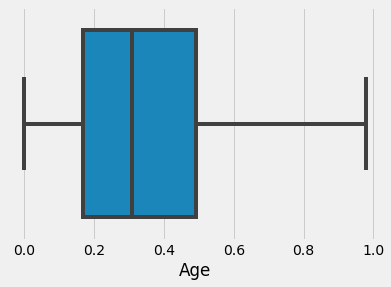

In [826]:
sns.boxplot(df1['Age'],data=df1)



---



---



**Family_Size**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Family_Size'>

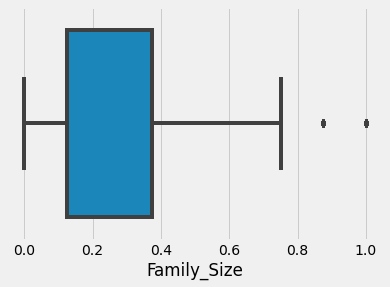

In [827]:
sns.boxplot(df1['Family_Size'],data=df1)

In [828]:
Q1 = df1['Family_Size'].quantile(0.25)
Q3 = df1['Family_Size'].quantile(0.75)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
print(upper_whisker)

0.75


In [829]:
#TREATMENT2: Replacing outliers with median values
median = df1.loc[df1['Family_Size']<0.75, 'Family_Size'].median()
df1.loc[df1.Family_Size > 0.75, 'Family_Size'] 
df1.fillna(median,inplace=True)
df1["Family_Size"] = df1["Family_Size"].mask(df1["Family_Size"] >0.75, median)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Family_Size'>

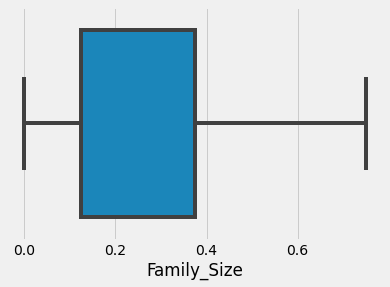

In [830]:
sns.boxplot(df1['Family_Size'],data=df1)

**Now all the data has been cleaned. There is no missing value and columns are in right format.
All the ids are unique that is there is no duplicate entry.
Created new column: 'Age_Bin', 'Work_Exp_Category' and 'Family_Size_Category'.**

###**MODEL BUILDING AND PREDICTION**

In [831]:
# Separating dependent-independent variables
X = df1.drop('Segmentation',axis=1)
y = df1['Segmentation']

In [832]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

In [833]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((6439, 23), (6439,), (1610, 23), (1610,))

In [836]:
rfc = RandomForestClassifier(n_trees=50, bootstrap=True, max_features=10, min_samples_leaf=8,random_state=123)
rfc.fit(X_train, y_train)
y_pred= rfc.predict(X_test)
acc_test = rfc.score(X_test, y_test)
acc_train = rfc.score(X_train, y_train)
print("Random Forest model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))

Random Forest model
train accuracy: 66.61%
test accuracy:  54.47%
